In [1]:
import pandas as pd
import lecilab_behavior_analysis.utils as utils
from pathlib import Path
%load_ext autoreload
%autoreload 2

In [ ]:
# mouse = "mouse2"
# df = utils.load_example_data(mouse)

In [2]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)

['auditory_escape_data', 'cate_task_data', 'COT_cannula_data', 'COT_test_data', 'visual_and_COT_data']


In [4]:
# see the available animals
project_idx = 2
animals = utils.get_animals_in_project(tv_projects[project_idx])
print(animals)

['NUO001', 'NUO002', 'NUO003', 'NUO004', 'NUO005', 'NUO006', 'NUO007', 'NUO008', 'NUO009', 'NUO010', 'NUO011', 'NUO012']


In [19]:
# download the data for a specific animal

# mouse = "mouse2"
# df = utils.load_example_data(mouse)

mouse = "NUO009"
local_path = Path(utils.get_outpath()) / Path(tv_projects[project_idx]) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_cluster_data(
    project_name=tv_projects[project_idx],
    file_path="sessions/{}/{}.csv".format(mouse, mouse),
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)

receiving incremental file list
NUO009.csv

sent 9,277 bytes  received 12,242,873 bytes  2,227,663.64 bytes/sec
total size is 75,048,574  speedup is 6.13


True

In [20]:
# load the data
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

/tmp/ipykernel_6485/1822815569.py:2: DtypeWarning: Columns (13,14,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


In [ ]:
# # engagement analysis
# from lecilab_behavior_analysis import df_transforms as dft
# df = dft.add_trial_duration_column_to_df(df)
# df = dft.add_engagement_column(df, engagement_sd_criteria=2)
# # load events
# events_df = utils.load_all_events(project_name=tv_projects[1])
# sbu_df = dft.get_box_usage_df(df, events_df)
# sbu_df = dft.add_day_column_to_df(sbu_df)

In [ ]:
# from lecilab_behavior_analysis import plots
# plots.plot_box_usage_by_date(sbu_df)

In [13]:
from lecilab_behavior_analysis.figure_maker import subject_progress_figure
# sync and load events
project_files = utils.get_folders_from_server(credentials=utils.get_idibaps_cluster_credentials(),
                                              path="/archive/training_village/{}".format(tv_projects[project_idx]))
local_path = Path(utils.get_outpath()) / Path(tv_projects[project_idx])
if "old_events" in project_files:
    events_files = ["old_events", "events.csv"]
else:
    events_files = ["events.csv"]
for file in events_files:     
    utils.rsync_cluster_data(
        project_name=tv_projects[project_idx],
        file_path=file,
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )


receiving incremental file list
old_events/
old_events/events_20250923_225229.csv
old_events/events_20251004_221207.csv
old_events/events_20251020_163027.csv

sent 88 bytes  received 658,365 bytes  188,129.43 bytes/sec
total size is 11,347,412  speedup is 17.23
receiving incremental file list
events.csv

sent 8,107 bytes  received 188,113 bytes  78,488.00 bytes/sec
total size is 2,041,099  speedup is 10.40


In [15]:
events_df = utils.load_all_events(project_name=tv_projects[project_idx])

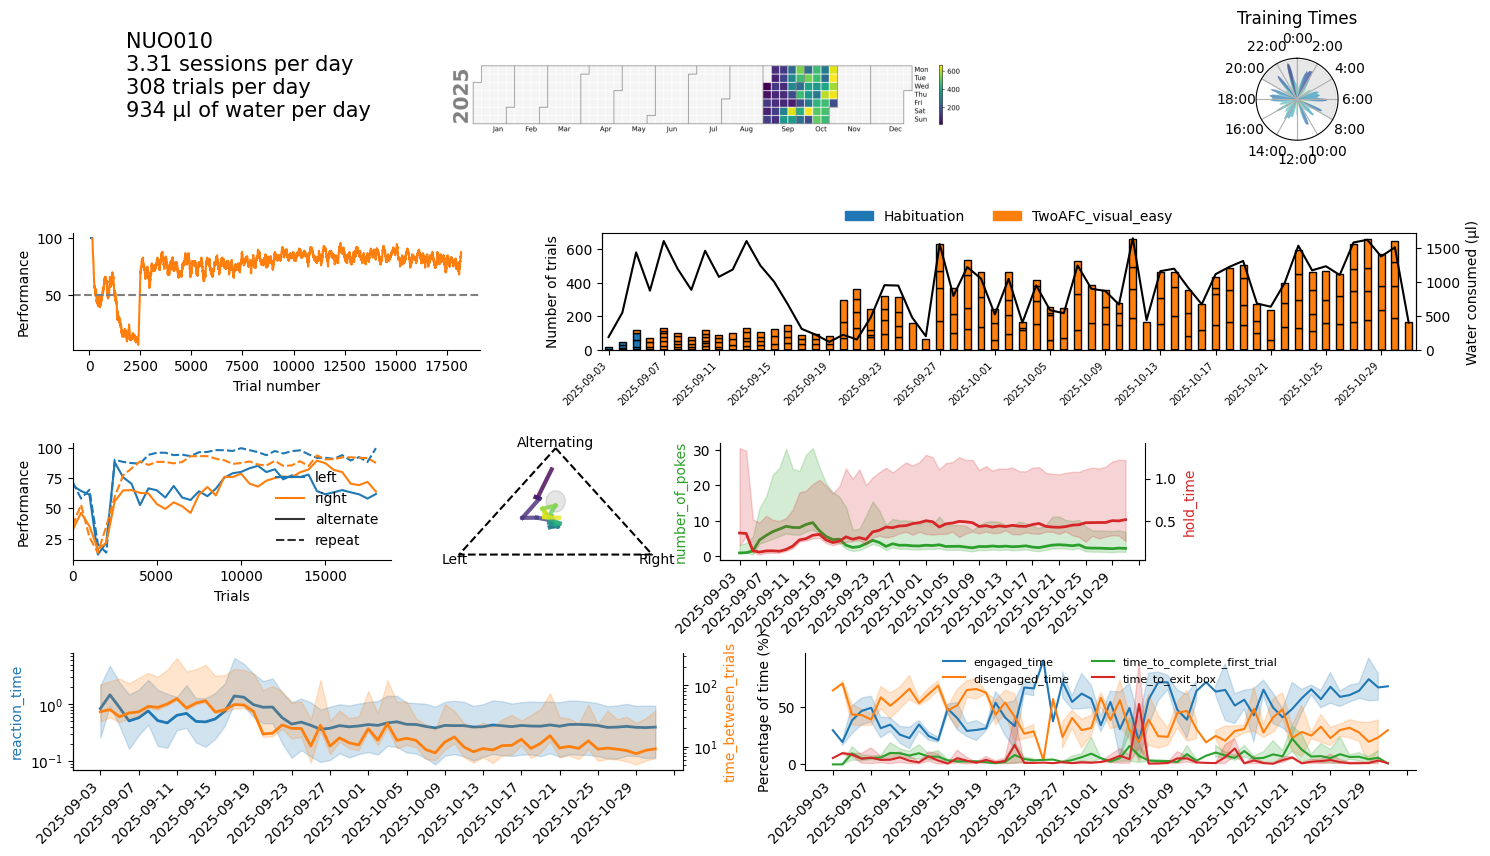

In [17]:
fig = subject_progress_figure(df, perf_window=100, summary_matrix_plot=False, events_df=events_df)

In [ ]:
# # load the data if cluster is down
# mouse_path = utils.get_outpath() + "/visual_and_COT_data/sessions/ACV008/ACV008.csv"
# df = pd.read_csv(mouse_path, sep=";")

/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/plots.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labels = df_copy[x].groupby(bin_groups).mean()


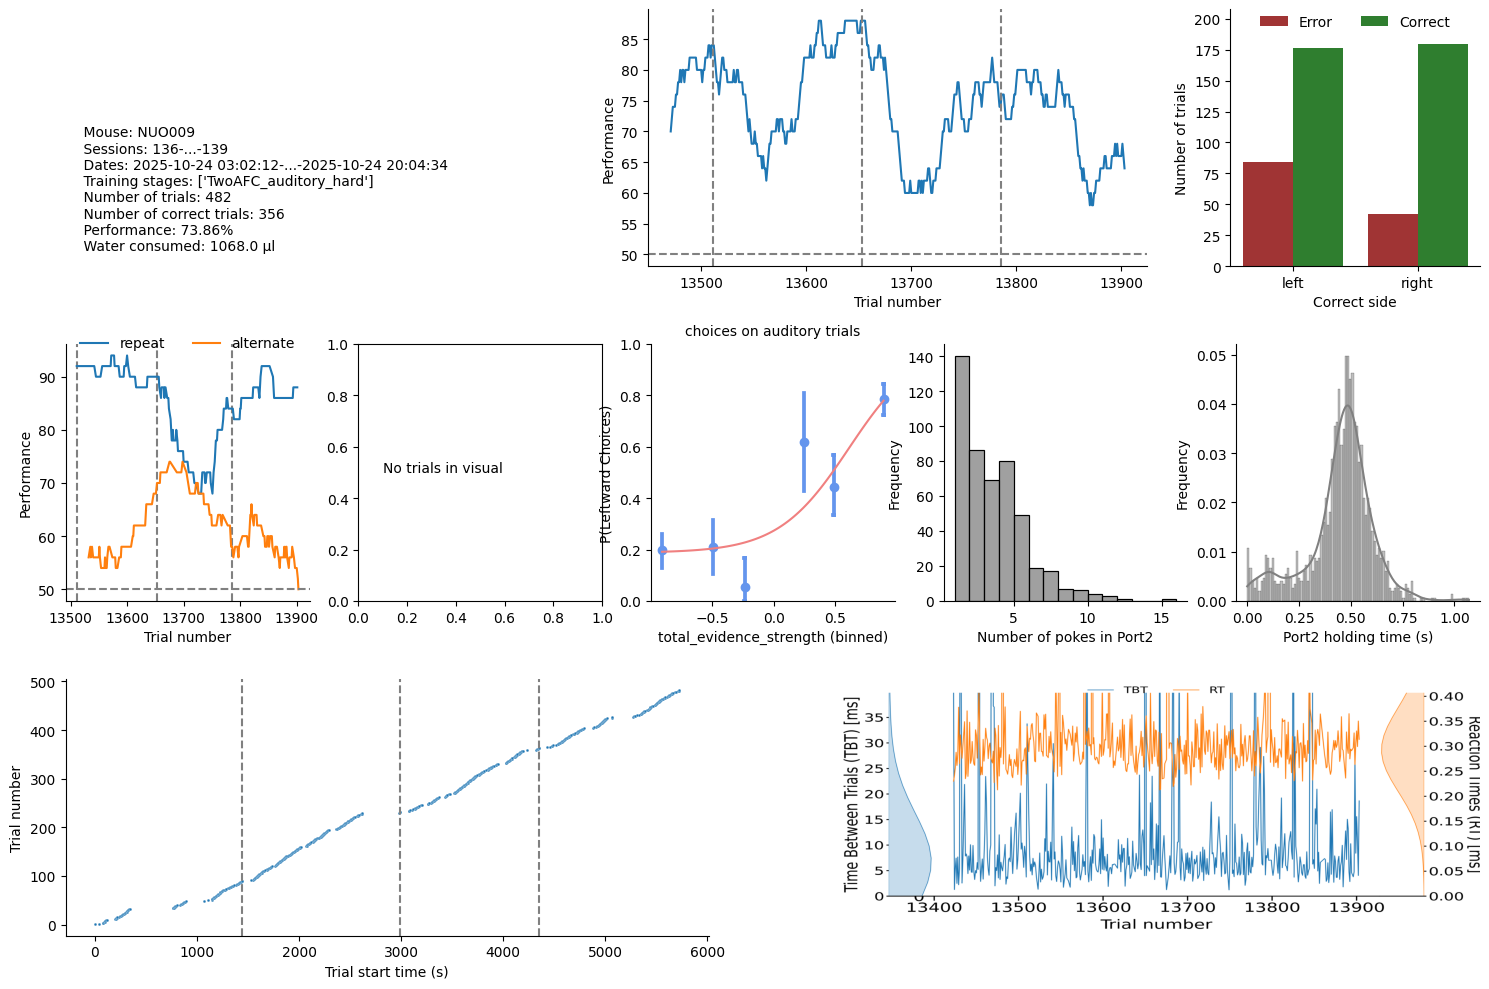

In [21]:
from lecilab_behavior_analysis.figure_maker import session_summary_figure
from lecilab_behavior_analysis.df_transforms import add_trial_of_day_column_to_df, add_day_column_to_df
import numpy as np
# select the session you want to plot
date = "2025-10-24"
# df = analyze_df(df)
df = add_day_column_to_df(df)
df = add_trial_of_day_column_to_df(df)
df['total_trial'] = np.arange(1, df.shape[0] + 1)
sdf = df[df["year_month_day"] == date]
# sdf = df[df["current_training_stage"] == "TwoAFC_auditory_hard"]
fig = session_summary_figure(sdf, perf_window=50, width=15, height=10)

In [ ]:
from lecilab_behavior_analysis import df_transforms as dft
from lecilab_behavior_analysis import utils
sdf = utils.add_time_from_session_start(sdf)

In [ ]:
sdf[sdf.session != sdf.session.shift(1)].index

In [ ]:
sdf = dft.adjust_trials_and_time_of_start_to_first_session(sdf)

In [ ]:
from lecilab_behavior_analysis import plots
# find the index of the session changes
session_changes = sdf[sdf.session != sdf.session.shift(1)].index
plots.plot_trial_time_of_start(sdf, session_changes=session_changes, width=15, height=10)